<a href="https://colab.research.google.com/github/picadud/BirdSoundClassification/blob/main/Birdsound_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


from google.colab import drive


# Remount Google Drive
drive.mount('/content/drive')
#!ls /content/drive/MyDrive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display  # For better visualization
import ast
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from google.colab import data_table
%matplotlib inline


In [ ]:

currentPath = '/content/drive/MyDrive/birdsound/birdClassification'
csv_path = os.path.join(currentPath, 'segmentedData.csv')
df = pd.read_csv(csv_path)
df['audio'] = df['converted_file_path'].apply(lambda x: librosa.load(os.path.join(currentPath,x), sr=44100)[0]) # interpret the WAV file

,Unnamed: 0.1,Unnamed: 0,en,file,file-name,type,length,date,smp,file_path,converted_file_path,segments,segments_count,audio,integer_code
0,0,0,Hooded Crow,https://xeno-canto.org/931935/download,XC931935-20240904_001_H1e_08_06_29.wav,call,0:07,2024-09-04,44100,AudioFile\XC931935-20240904_001_H1e_08_06_29.wav,audio_files/XC931935-20240904_001_H1e_08_06_29...,"[((0.5688888888888889), (1.1145578231292517)),...",4,"[0.004470825, 0.0054016113, 0.005203247, 0.005...",1
1,1,1,Hooded Crow,https://xeno-canto.org/930288/download,XC930288-20240827_001_H1e_08_05_48.wav,call,0:04,2024-08-27,44100,AudioFile\XC930288-20240827_001_H1e_08_05_48.wav,audio_files/XC930288-20240827_001_H1e_08_05_48...,"[((0.7314285714285714), (1.0448979591836736)),...",7,"[0.0036773682, 0.0058288574, 0.006378174, 0.00...",1
2,2,2,Hooded Crow,https://xeno-canto.org/930082/download,XC930082-20240826_001_H1e_09_03_53.wav,call,0:22,2024-08-26,48000,AudioFile\XC930082-20240826_001_H1e_09_03_53.wav,audio_files/XC930082-20240826_001_H1e_09_03_53...,"[((2.020136054421769), (2.6006349206349206)), ...",4,"[0.0040619103, 0.004603587, 0.003918156, 0.004...",1
3,3,3,Hooded Crow,https://xeno-canto.org/929213/download,XC929213-20240822_LSP5_0183_10_02_48.wav,call,0:08,2024-08-22,48000,AudioFile\XC929213-20240822_LSP5_0183_10_02_48...,audio_files/XC929213-20240822_LSP5_0183_10_02_...,"[((5.921088435374149), (6.42031746031746))]",1,"[0.00065024616, 0.0005931336, 0.00057572103, 0...",1
4,4,4,Hooded Crow,https://xeno-canto.org/931936/download,XC931936-20240904_001_H1e_08_28_19.wav,"call, subsong, Juvenile grunt",0:18,2024-09-04,44100,AudioFile\XC931936-20240904_001_H1e_08_28_19.wav,audio_files/XC931936-20240904_001_H1e_08_28_19...,"[((0.29024943310657597), (0.8591383219954648))...",12,"[0.0015106201, 0.0018310547, 6.1035156e-05, -0...",1


In [ ]:

#code to convert the original dataframe to the ideal format and shape in google colab, only use once
df['converted_file_path'] = df['converted_file_path'].apply(lambda x: x.replace('\\', '/').replace('AudioFilesInWav', 'audio_files'))

labels = df['en'].unique()
# 1. Integer Encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)

species_dict = {}
for i, species in enumerate(label_encoder.classes_):
  species_dict[species] = integer_encoded[i]
print(species_dict)
df['integer_code'] = df['en'].map(species_dict)
df['segments'] = df['segments'].str.replace('np.float64', '')
#df.to_csv('segmentedData.csv')

{'Barnacle Goose': 2, 'Eurasian Penduline Tit': 4, 'Hooded Crow': 1, 'Oriental Cuckoo': 0, 'Whooper Swan': 3}


In [ ]:
#to test out the best parameters to use for mfccs extraction, only run once to get the result, the result is then stored
sr = 44100
# Define parameter arrays
n_mfcc_vals = [13, 20]
n_fft_vals = [64, 128, 256]
hop_length_vals = [32, 64, 128]
n_mels_vals = [20, 32, 40, 64]
lifter_vals = [0, 22]
results = []
for n_mfcc in n_mfcc_vals:
    for n_fft in n_fft_vals:
        for hop_length in hop_length_vals:
            for n_mels in n_mels_vals:
                for lifter in lifter_vals:
                  X = []
                  y = []
                  for index, row in df.iterrows():
                    # Access data from each row using row['column_name']
                    audio_data = row['audio']
                    species = row['en']
                    integer_code = row['integer_code']
                    segments = ast.literal_eval(row['segments'])
                    for segment in segments:
                        start, end = segment

                        # Extract the segment from the audio
                        segment_audio = audio_data[int(start * sr):int(end * sr)]

                        # Extract MFCC features for the segment
                        mfccs = librosa.feature.mfcc(y=segment_audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft,n_mels = n_mels, hop_length = hop_length, lifter = lifter)
                        mfccs_mean = np.mean(mfccs, axis=1)
                        mfccs_std = np.std(mfccs, axis=1)
                        mfccs_features = np.concatenate((mfccs_mean, mfccs_std))
                        X.append(mfccs_features)
                        y.append(integer_code)


                  X = np.array(X).reshape(np.array(X).shape[0], -1)
                  y = np.array(y)

                  # Split the dataset into training and testing sets
                  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                  # Standardize the features
                  scaler = StandardScaler()
                  X_train = scaler.fit_transform(X_train)
                  X_test = scaler.transform(X_test)

                  # Train the SVM classifier
                  svm = SVC(kernel='linear', C=1)
                  svm.fit(X_train, y_train)

                  # Predict on the test set
                  y_pred = svm.predict(X_test)

                  # Evaluate accuracy
                  accuracy = accuracy_score(y_test, y_pred)

                  # Set up k-fold cross-validation (k = 5)
                  kf = KFold(n_splits=5, shuffle=True, random_state=42)
                  X_scaled = scaler.fit_transform(X)
                  # Perform cross-validation and get accuracy scores

                  validation_scores = cross_val_score(svm, X_scaled, y, cv=kf, scoring='accuracy')
                  #print("Accuracy for each fold:", validation_scores)
                  #print("Mean accuracy:", validation_scores.mean())
                  result = {
                        'n_mfcc': n_mfcc,
                        'n_fft': n_fft,
                        'hop_length': hop_length,
                        'n_mels': n_mels,
                        'lifter': lifter,
                        'accuracy': accuracy,
                        'validation_scores': validation_scores.mean()
                    }
                  results.append(result)
df_results = pd.DataFrame(results)
df_results = df_results.drop_duplicates().sort_values(by='validation_scores', ascending=False)
df_results.to_csv('results.csv', index=False)
max_row = df_results.head(20)
print(max_row)

In [ ]:
#the best parameter combos
mfcc_csv_path = os.path.join(currentPath, 'top20mfccParams.csv')
mfccParams = pd.read_csv(mfcc_csv_path)
print(mfccParams)

    n_mfcc  n_fft  hop_length  n_mels  accuracy  validation_scores
0       20    128          64      64  0.966038           0.968673
1       20    128          32      64  0.964151           0.968669
2       20     64          32      40  0.956604           0.966029
3       20     64          32      64  0.949057           0.964519
4       20     64          32      32  0.950943           0.964139
5       20    256          64      64  0.956604           0.963764
6       20     64          64      64  0.954717           0.963388
7       20    256          32      64  0.954717           0.963010
8       20    256          32      32  0.949057           0.963009
9       20     64          64      40  0.956604           0.961499
10      20    256          64      32  0.950943           0.961499
11      20    256         128      64  0.954717           0.961123
12      20     64          64      40  0.956604           0.961121
13      20    256         128      32  0.939623           0.96

In [ ]:
#use the best paramter combo to extract the features
sr = 44100
X = []
y = []
for index, row in df.iterrows():
  # Access data from each row using row['column_name']
    audio_data = row['audio']
    species = row['en']
    integer_code = row['integer_code']
    segments = ast.literal_eval(row['segments'])
    for segment in segments:
        start, end = segment

        # Extract the segment from the audio
        segment_audio = audio_data[int(start * sr):int(end * sr)]

        # Extract MFCC features for the segment
        mfccs = librosa.feature.mfcc(y=segment_audio, sr=sr, n_mfcc=20, n_fft=128,n_mels = 64, hop_length = 64)

        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)
        mfccs_features = np.concatenate((mfccs_mean, mfccs_std))
        X.append(mfccs_features)
        y.append(integer_code)

X = np.array(X).reshape(np.array(X).shape[0], -1)
y = np.array(y)
#print(X.shape)
#print(y.shape)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


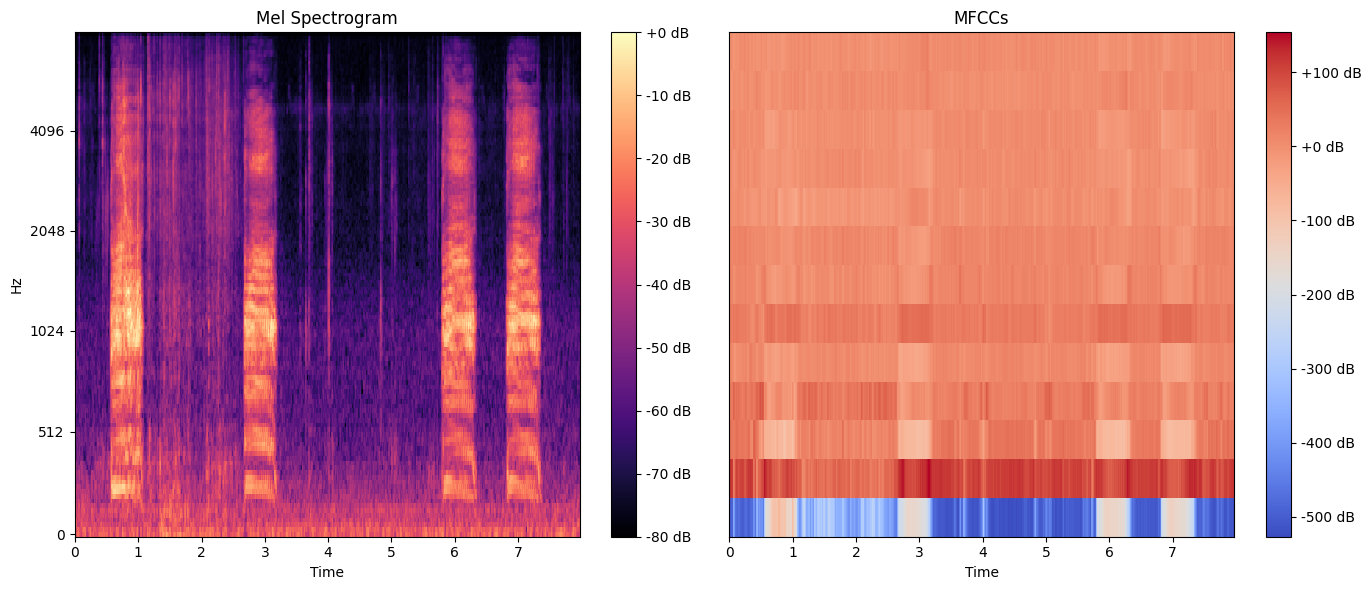

In [ ]:
#example mel_sepctrogram and mfccs figure
example_audio = df['audio'].iloc[0]
# Extract MFCC features
mfccs = librosa.feature.mfcc(y=example_audio, sr=sr, n_mfcc=13)

# Extract Mel Spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=example_audio, sr=sr, n_mels=128)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to dB for better visualization

# Create subplots
plt.figure(figsize=(14, 6))

# Plot Mel Spectrogram
plt.subplot(1, 2, 1)
librosa.display.specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')

# Plot MFCCs
plt.subplot(1, 2, 2)
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCCs')

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
#results with default parameters for SVM
svm_basic = SVC(random_state=42)
svm_basic.fit(X_train, y_train)
y_pred = svm_basic.predict(X_test)
# Evaluate accuracy
accuracy_basic = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_basic * 100:.2f}%")

# Print classification report
print(classification_report(y_test, y_pred))

Accuracy: 96.98%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       142
           1       0.95      1.00      0.98        21
           2       0.97      1.00      0.98       139
           3       1.00      0.82      0.90        71
           4       0.99      0.98      0.99       157

    accuracy                           0.97       530
   macro avg       0.97      0.96      0.96       530
weighted avg       0.97      0.97      0.97       530



In [ ]:
#searching for the best hyperparameters
param_grid = {
    'C': [0.1, 1, 10, 100],              # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'], # Different kernels
    'gamma': [0.001, 0.01, 0.1, 1],     # Kernel coefficient (for rbf, poly)
    'degree': [2, 3, 4],                 # Degree of the polynomial (for poly kernel)
    'class_weight': ['balanced']  # Class weights for imbalanced classes
}
# Train the SVM classifier

svm = SVC()

# Use GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'class_weight': ['balanced'],
                         'degree': [2, 3, 4], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [ ]:
# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy) #best mean cross validation scores
#use the best parameters to train the data
svm = SVC(
    C=best_params['C'],
    kernel=best_params['kernel'],
    gamma=best_params['gamma'],  # gamma is not relevant for 'linear' kernel
    degree=best_params['degree'],       # degree only relevant for 'poly' kernel
    class_weight=best_params['class_weight'],       # degree only relevant for 'poly' kernel
    random_state = 42
)
svm.fit(X_train, y_train)

# Predict on the test set
y_pred = svm.predict(X_test)

Best Hyperparameters: {'C': 10, 'class_weight': 'balanced', 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
Best Accuracy: 0.9830144074222759


Accuracy: 98.68%
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       142
           1       1.00      1.00      1.00        21
           2       0.97      1.00      0.98       139
           3       1.00      0.94      0.97        71
           4       1.00      0.98      0.99       157

    accuracy                           0.99       530
   macro avg       0.99      0.98      0.99       530
weighted avg       0.99      0.99      0.99       530



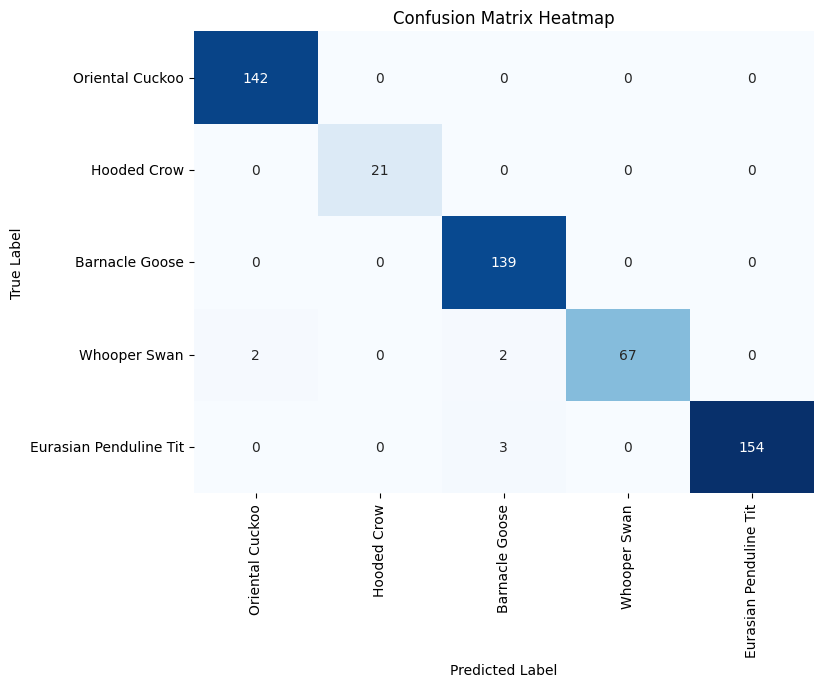

In [ ]:
#results and visualization for fine-tuned SVM
labels = ['Oriental Cuckoo', 'Hooded Crow', 'Barnacle Goose', 'Whooper Swan', 'Eurasian Penduline Tit']
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report
print(classification_report(y_test, y_pred))# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
#get the results for Random forest use mostly the default parameters
# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the model
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
# Evaluate the model performance
print(classification_report(y_test, y_pred_rf))
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       142
           1       0.95      0.90      0.93        21
           2       0.96      0.99      0.98       139
           3       0.98      0.89      0.93        71
           4       0.99      0.98      0.98       157

    accuracy                           0.97       530
   macro avg       0.97      0.95      0.96       530
weighted avg       0.97      0.97      0.97       530

Accuracy: 97.17%


In [ ]:

#fine_tuning the parameters
# Define the parameter grid
param_grid_rf = {

    'n_estimators': [100, 200, 300],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt',0.5, None],
    'class_weight': ['balanced', 'balanced_subsample'],


}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Grid search with cross-validation (cv=5)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)



Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'max_features': ['sqrt', 0.5, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [10, 20, 30],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [ ]:

# Get the best hyperparameters
best_params_rf = grid_search_rf.best_params_
best_accuracy_rf = grid_search_rf.best_score_
print("Best hyperparameters: ", best_params_rf)
print("Best Accuracy:", best_accuracy_rf)

Best hyperparameters:  {'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best Accuracy: 0.9792330166376733


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       142
           1       1.00      1.00      1.00        21
           2       0.97      1.00      0.98       139
           3       0.98      0.92      0.95        71
           4       0.99      0.98      0.98       157

    accuracy                           0.98       530
   macro avg       0.99      0.98      0.98       530
weighted avg       0.98      0.98      0.98       530

Accuracy: 98.30%


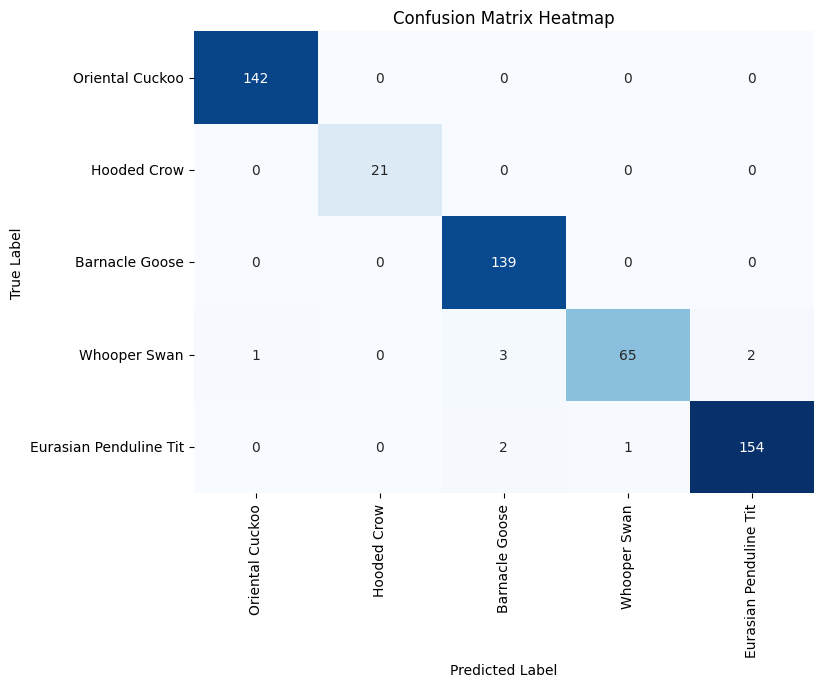

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf= best_params_rf['min_samples_leaf'],
    max_features= best_params_rf['max_features'],
    class_weight= best_params_rf['class_weight'],
    random_state = 42
)

# Train the model
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
# Evaluate the model performance
print(classification_report(y_test, y_pred_rf))
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")

cm_rf = confusion_matrix(y_test, y_pred_rf)
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()
